In [2]:
import tdb
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
data = tdb.load_tdb("hprc_105.tdb/",
                    lfilters=[("chrom", "=", "chr4")]) 
metadata = (pd.read_csv("igsr_samples.tsv", sep='\t')
                .where(lambda x: x["Sample name"].isin(data["sample"].keys()))
                .dropna())

Here I am trying to calculate Fst for all the tandem repeat we have in the databases following the defintion in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3141729/#APP1title

![alt text](fst.png "Title")

I will calculate w first from the metada and not in the larger natural population for simplicity

In [4]:
counts = metadata["Superpopulation code"].value_counts()
w = counts / counts.sum()

In [5]:
data['allele'].head()

,LocusID,allele_number,allele_length,sequence
0,604481,0,85,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...
1,604481,1,87,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...
2,604481,2,83,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...
3,604481,3,89,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...
4,604481,4,93,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...


In [6]:
samples_per_pop = metadata.groupby('Superpopulation code')['Sample name'].agg(list)



In [6]:
def hasVariant(df, locus, allele):
    condition = (df['LocusID'] == locus) & (df['allele_number'] == allele)
    return df[condition].shape[0] > 0



In [112]:
data['sample']['HG01887'].head(1)['LocusID']

TypeError: NDFrame.get() missing 1 required positional argument: 'key'

In [7]:
locusID = 604481
allele_number = 3

def calculateFst(locus_row):
    locusID = locus_row['LocusID']
    allele_number = locus_row['allele_number']
    Hs = 0
    Ht_1 = 0
    Ht_2 = 0
    for pop in samples_per_pop.keys():
        number_of_haps = len(samples_per_pop[pop])*2
        has_variants = [hasVariant(data['sample'][s], locusID, allele_number) for s in samples_per_pop[pop]]
        pk = sum(has_variants)/number_of_haps
        qk = 1-pk
        Hs += 2 * w[pop] * pk * qk
        Ht_1 +=  w[pop] * pk 
        Ht_2 +=  w[pop] * qk 
    
    Ht = 2* Ht_1 * Ht_2
    
    Fst = 1 - (Hs/Ht)
    return Fst
    
df = data['allele'].head(10)
df['fst'] = df.apply(calculateFst, axis=1)
df
#calculateFst(data['sample']['HG01887'].head(1))


/var/folders/4f/v5q9cq3n38xfxdz6wmvr39h80000gp/T/ipykernel_12914/1232242501.py:21: RuntimeWarning: invalid value encountered in scalar divide
  Fst = 1 - (Hs/Ht)
/var/folders/4f/v5q9cq3n38xfxdz6wmvr39h80000gp/T/ipykernel_12914/1232242501.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fst'] = df.apply(calculateFst, axis=1)


,LocusID,allele_number,allele_length,sequence,fst
0,604481,0,85,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...,0.013590
1,604481,1,87,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...,0.007131
2,604481,2,83,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...,0.033183
3,604481,3,89,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...,0.020646
4,604481,4,93,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...,NaN
5,604481,5,91,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...,0.027007
6,604481,6,91,b'TTACTATGAGATTGCTATCCACTATTTATGTGTGTGTGTGTGTG...,0.013986
7,604481,7,91,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...,0.015597
8,604481,8,87,b'TTACTATGAGATTGCTATCCACTATTTATGTGTGTGTGTGTGTG...,0.013986
9,604481,9,90,b'TTACTATGAGATTGCTATCCACTATTTATATGTGTGTGTGTGTG...,0.015597


In [33]:
df=data['allele'].head(50000)

In [34]:
data['allele'].shape

(762908, 4)

In [35]:
df['fst'] = df.apply(calculateFst, axis=1)

/var/folders/4f/v5q9cq3n38xfxdz6wmvr39h80000gp/T/ipykernel_12914/1232242501.py:21: RuntimeWarning: invalid value encountered in scalar divide
  Fst = 1 - (Hs/Ht)
/var/folders/4f/v5q9cq3n38xfxdz6wmvr39h80000gp/T/ipykernel_12914/285360551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fst'] = df.apply(calculateFst, axis=1)


In [50]:
sum(df['fst'] >0.2)

33

In [43]:

df[df['fst'] >0.2]

,LocusID,allele_number,allele_length,sequence,fst
9808,605100,9,1162,b'AGTGTCCTGTCCTTCATACCATTCCCTAGAATGGAGGAGGGGTG...,0.230136
11076,605159,0,407,b'TGACCAACATGGTGAAACCCTGTCTCTACTAAAAATACAAAAAT...,0.262255
13811,605327,5,94,b'CTGAGCAGGCCTCTGTCTCTGGGCCTGGCTGCTGGGGCCGAGCA...,0.200970
17427,605590,4,104,b'AAATTTATTAGCTGATATTTGATTTAGGACGTGTGTGTGTGTGC...,0.243292
23297,605993,25,967,b'CATGGCCCGTTCTCAATGAGCTGTTGAGTACACCTCCCAGACGG...,0.226767
23923,606022,2,183,b'TTCCGGTTCGGAAGCCGAGGAGGAGCGCATGAGAGCCACAGCCC...,0.200970
24400,606045,4,95,b'ACAGCTGGTTTGTAGTGGGTGTGCTGTGGTTTATTATTATTATT...,0.200970
25054,606097,4,191,b'TTACAATCCACCAAGGAAAAGGCACATGTGGAGAGTCAGGGAGA...,0.266412
25320,606113,3,70,b'CTTCATGAAAACATTTAATGCTGCTTTTAAAACAACAACAACAA...,0.233124
25397,606119,2,401,b'GGTGATATTCCTCCTAATATTCCCGGAAGAAGAGAATGCTATTA...,0.200970


In [44]:
data['allele'][data['allele']['LocusID'] == 607625]

,LocusID,allele_number,allele_length,sequence
47883,607625,0,683,b'TTCTGAAAGGAAAACCACACACACGTACACAGAGGAAGAAAGTG...
47884,607625,1,683,b'TTCTGAAAGGAAAACCACACACACGTACACAGAGGAAGAAAGTG...
47885,607625,2,683,b'TTCCGAAAGGAAAATCACACACACGTACACAGAGGAAGAAAGTG...
47886,607625,3,682,b'TTCTGAAAGGAAAACCACACACACGTACACAGAGGAAGAAAGTG...
47887,607625,4,1040,b'TTCTGAAAGGAAAACCACACACACGTACACAGAGGAAGAAAGTG...
47888,607625,5,683,b'TTCTGAAAGGAAAACCACACACACGTACACAGAGGAAGAAAGTG...
47889,607625,6,1040,b'TTCTGAAAGGAAAACCACACACACGTACACAGAGGAAGAAAGTG...
47890,607625,7,1040,b'TTCTGAAAGGAAAACCACACACACGTACACAGAGGAAGAAAGTG...
47891,607625,8,682,b'TTCTGAAAGGAAAACCACACACACGTACACAGAGGAAGAAAGTG...
47892,607625,9,683,b'TTCTGAAAGGAAAACCACACACACGTACACAGACGAAGAAAGTG...


In [53]:
def findTaggingAncestary(locus_row):
    locusID = locus_row['LocusID']
    allele_number = locus_row['allele_number']
    for pop in samples_per_pop.keys():
        has_variants = [hasVariant(data['sample'][s], locusID, allele_number) for s in samples_per_pop[pop]]
        res[pop] = sum(has_variants) 
    print(res)

highSignal = df[df['fst'] >0.2]
highSignal['ancst'] = highSignal.apply(findTaggingAncestary, axis=1)
    

{'AFR': 19, 'AMR': 2, 'EAS': 1, 'SAS': 0}
{'AFR': 22, 'AMR': 1, 'EAS': 2, 'SAS': 1}
{'AFR': 16, 'AMR': 2, 'EAS': 0, 'SAS': 0}
{'AFR': 16, 'AMR': 0, 'EAS': 0, 'SAS': 0}
{'AFR': 15, 'AMR': 0, 'EAS': 0, 'SAS': 0}
{'AFR': 16, 'AMR': 2, 'EAS': 0, 'SAS': 0}
{'AFR': 16, 'AMR': 2, 'EAS': 0, 'SAS': 0}
{'AFR': 21, 'AMR': 3, 'EAS': 0, 'SAS': 0}
{'AFR': 19, 'AMR': 3, 'EAS': 0, 'SAS': 0}
{'AFR': 16, 'AMR': 2, 'EAS': 0, 'SAS': 0}
{'AFR': 16, 'AMR': 0, 'EAS': 0, 'SAS': 0}
{'AFR': 26, 'AMR': 10, 'EAS': 1, 'SAS': 2}
{'AFR': 15, 'AMR': 0, 'EAS': 0, 'SAS': 0}
{'AFR': 21, 'AMR': 2, 'EAS': 0, 'SAS': 0}
{'AFR': 19, 'AMR': 2, 'EAS': 0, 'SAS': 0}
{'AFR': 17, 'AMR': 2, 'EAS': 0, 'SAS': 0}
{'AFR': 19, 'AMR': 2, 'EAS': 1, 'SAS': 1}
{'AFR': 16, 'AMR': 2, 'EAS': 0, 'SAS': 0}
{'AFR': 19, 'AMR': 5, 'EAS': 0, 'SAS': 0}
{'AFR': 15, 'AMR': 1, 'EAS': 0, 'SAS': 0}
{'AFR': 17, 'AMR': 0, 'EAS': 1, 'SAS': 0}
{'AFR': 19, 'AMR': 3, 'EAS': 0, 'SAS': 0}
{'AFR': 17, 'AMR': 2, 'EAS': 0, 'SAS': 0}
{'AFR': 15, 'AMR': 1, 'EAS': 0, '

/var/folders/4f/v5q9cq3n38xfxdz6wmvr39h80000gp/T/ipykernel_12914/1368691473.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highSignal['ancst'] = highSignal.apply(findTaggingAncestary, axis=1)


In [8]:
allele_ac = pd.read_csv("result.txt", sep='\t')

In [9]:
def calculateFst_allele(locus_row):
    Hs = 0
    Ht_1 = 0
    Ht_2 = 0
    for pop in samples_per_pop.keys():
        number_of_haps = len(samples_per_pop[pop])*2
        pk = locus_row[f"AC_{pop}"]/number_of_haps
        qk = 1-pk
        Hs += 2 * w[pop] * pk * qk
        Ht_1 +=  w[pop] * pk 
        Ht_2 +=  w[pop] * qk 
    
    Ht = 2* Ht_1 * Ht_2
    
    Fst = 1 - (Hs/Ht)
    return Fst

allele_ac['fst'] = allele_ac.apply(calculateFst_allele, axis=1)
allele_ac

/var/folders/4f/v5q9cq3n38xfxdz6wmvr39h80000gp/T/ipykernel_21247/2804901453.py:15: RuntimeWarning: invalid value encountered in scalar divide
  Fst = 1 - (Hs/Ht)


,chrom,start,end,is_ref,AC,AF,AC_EAS,AC_AMR,AC_AFR,AC_SAS,fst
0,chr1,16682,16774,True,161,0.856383,16,28,26,24,0.000000
1,chr1,16682,16774,False,27,0.143617,4,8,9,6,0.003152
2,chr1,19275,19473,True,178,0.946809,16,28,26,24,0.000000
3,chr1,19275,19473,False,10,0.053191,0,2,7,1,0.053089
4,chr1,20798,20893,True,146,0.776596,16,28,26,24,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
7092746,chrY,56887081,56887171,False,4,0.042553,0,2,2,0,0.016155
7092747,chrY,56887081,56887171,True,1,0.010638,0,1,0,0,0.012605
7092748,chrY,56887081,56887171,False,1,0.010638,0,0,1,0,0.013986
7092749,chrY,56887081,56887171,False,1,0.010638,0,0,1,0,0.013986


In [79]:
signficant = allele_ac[allele_ac['fst'] > 0.2]

In [90]:
def highest_ancestry(row):
    tmp = sorted([[row[f"AC_{pop}"],pop] for pop in samples_per_pop.keys()],reverse = True)
    return tmp[0][1]

signficant['POP']= signficant.apply(highest_ancestry, axis=1)
signficant

/var/folders/4f/v5q9cq3n38xfxdz6wmvr39h80000gp/T/ipykernel_12914/1993291271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signficant['POP']= signficant.apply(highest_ancestry, axis=1)


,chrom,start,end,is_ref,AC,AF,AC_EAS,AC_AMR,AC_AFR,AC_SAS,fst,POP
2451,chr1,811203,811298,False,34,0.180851,1,4,21,1,0.213685,AFR
3390,chr1,1010436,1010564,True,32,0.170213,0,5,20,1,0.203703,AFR
3505,chr1,1041648,1041887,True,39,0.207447,2,5,24,1,0.234336,AFR
5276,chr1,1360820,1361267,False,20,0.106383,0,1,15,0,0.203786,AFR
5723,chr1,1432980,1433106,False,16,0.085106,12,0,1,0,0.299172,EAS
...,...,...,...,...,...,...,...,...,...,...,...,...
7088486,chrY,19300437,19300696,False,8,0.160000,8,0,0,0,0.216667,EAS
7088694,chrY,19555732,19555827,False,10,0.200000,9,0,0,1,0.213366,EAS
7089346,chrY,21640481,21640564,False,9,0.180000,9,0,0,0,0.245112,EAS
7089828,chrY,22358502,22358590,False,9,0.180000,9,0,0,0,0.245112,EAS


In [78]:
allele_ac.to_csv('result_fst.tsv', sep="\t") 

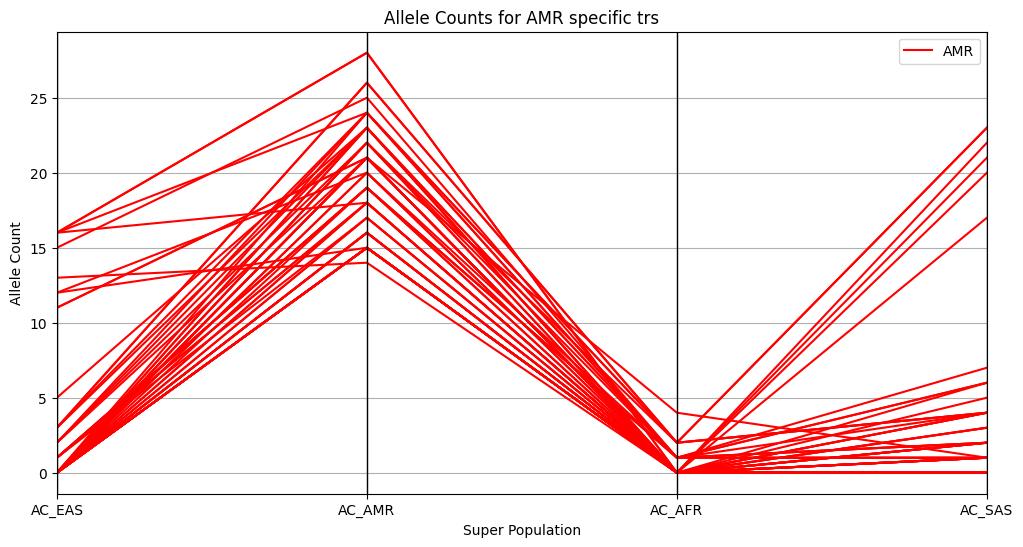

In [104]:
#%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

signficant_plot =  signficant[ signficant['POP'] == 'EAS']
signficant_plot =  signficant_plot[ ['POP', 'AC_EAS', 'AC_AMR', 'AC_AFR', 'AC_SAS']]

plt.figure(figsize=(12, 6))
parallel_coordinates(signficant_plot,'POP' ,color=["#FF0000", "#00FF00", "#0000FF", "#FFFF00"])
plt.title('Allele Counts for EAS specific trs')
plt.xlabel('Super Population')
plt.ylabel('Allele Count')
plt.grid(True)
plt.show()

In [108]:
import pandas as pd

lp = pd.read_csv("hprc_105_len_poly_score.txt", sep='\t')
fst = pd.read_csv("result_fst.tsv", sep='\t')

lp.set_index(['chrom', 'start', 'end'], inplace=True)
fst.set_index(['chrom', 'start', 'end'], inplace=True)

fst['len_poly_score'] = lp['len_poly_score']
fst.head()

Unnamed: 0  is_ref   AC        AF  AC_EAS  AC_AMR  AC_AFR  \
chrom start end                                                                
chr1  16682 16774           0    True  161  0.856383      16      28      26   
            16774           1   False   27  0.143617       4       8       9   
      19275 19473           2    True  178  0.946809      16      28      26   
            19473           3   False   10  0.053191       0       2       7   
      20798 20893           4    True  146  0.776596      16      28      26   

                   AC_SAS       fst  len_poly_score  
chrom start end                                      
chr1  16682 16774      24  0.000000        1.904762  
            16774       6  0.003152        1.904762  
      19275 19473      24  0.000000        1.904762  
            19473       1  0.053089        1.904762  
      20798 20893      24  0.000000        1.904762

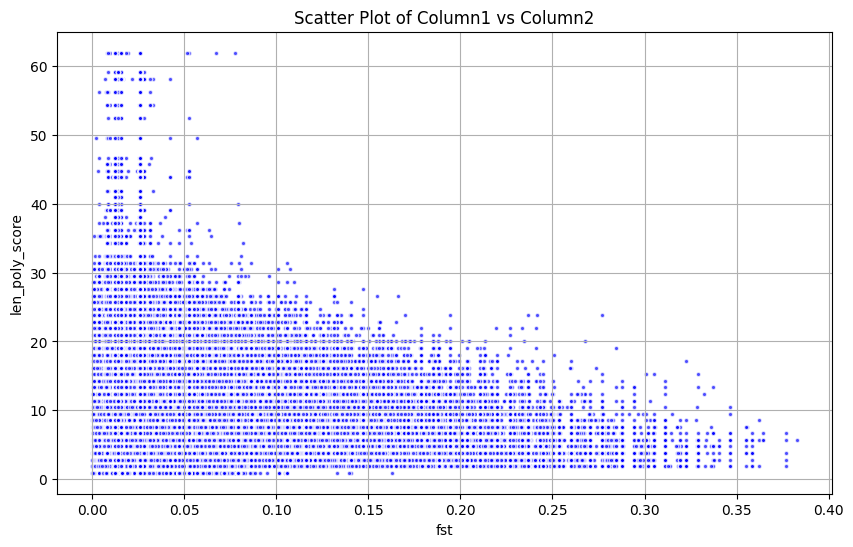

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(fst['fst'], fst['len_poly_score'], color='blue', alpha=0.7, edgecolors='w', s=10)
plt.title('Scatter Plot of Column1 vs Column2')
plt.xlabel('fst')
plt.ylabel('len_poly_score')
plt.grid(True)
plt.show()

In [119]:
import seaborn as sns

In [ ]:


# Create a pivot table to prepare data for heatmap
# Here we use a simple example where we are just using one column for each axis and a value for the heatmap.
pivot_table = pd.crosstab(fst['fst'], fst['len_poly_score'])
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='g', cbar=True)
plt.title('Heatmap of fst vs len_poly_score')
plt.xlabel('Clen_poly_score')
plt.ylabel('fst')
plt.show()

In [25]:
def calculateFst_allele_pairwise(locus_row):
    Hs = 0
    Ht_1 = 0
    Ht_2 = 0
    for pop in  ['SAS','AFR']:
        number_of_haps = len(samples_per_pop[pop])*2
        pk = locus_row[f"AC_{pop}"]/number_of_haps
        qk = 1-pk
        Hs += 2 * w[pop] * pk * qk


    for pop in ['SAS','AFR']:
        number_of_haps = len(samples_per_pop[pop])*2
        pk = locus_row[f"AC_{pop}"]/number_of_haps
        qk = 1-pk
        Ht_1 +=  w[pop] * pk 
        Ht_2 +=  w[pop] * qk 
    
    Ht = 2* Ht_1 * Ht_2
    
    Fst = 1 - (Hs/Ht)
    return Fst

allele_ac['pop_SAS_AFR'] = allele_ac.apply(calculateFst_allele_pairwise, axis=1)
sum(allele_ac['pop_SAS_AFR'] >0)

/var/folders/4f/v5q9cq3n38xfxdz6wmvr39h80000gp/T/ipykernel_21247/3659674429.py:21: RuntimeWarning: invalid value encountered in scalar divide
  Fst = 1 - (Hs/Ht)


0

In [24]:
sum(allele_ac['pop_SAS_AFR'] >0.8)

910512